In [1]:
import os
import cv2
import numpy as np
import torch
from torch.autograd import Variable

%matplotlib inline
from matplotlib import pylab as plt

In [2]:
def get_normalized(P1, P2):
    if isinstance(P1, list):
        P1 = torch.FloatTensor(P1)
    if isinstance(P2, list):
        P2 = torch.FloatTensor(P2)
    # 1.中心化
    p1_c, p2_c = P1.mean(dim=0), P2.mean(dim=0)
    print('p1_c:', p1_c)
    print('p2_c:', p2_c)
    P1 -= p1_c
    P2 -= p2_c
    # 2.归一化
    # D1, D2 = [], []
    # for p1, p2 in zip(P1, P2):
    #     D1.append(get_distance(p1, p1_c))
    #     D2.append(get_distance(p2, p2_c))
    # d1 = max(D1)  # -> tensor
    # d2 = max(D2)
    # P1 /= d1
    # P2 /= d2
    return P1, P2

In [3]:
def get_distance(p1, p2):
    if isinstance(p1, list):
        p1 = torch.FloatTensor(p1)
    if isinstance(p2, list):
        p2 = torch.FloatTensor(p2)
    d = torch.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)
    return d

In [4]:
def get_perspective(p, H):
    x, y = p
    src = torch.FloatTensor([x, y, 1]).reshape(3, 1)
    u, v, w = torch.mm(H, src)
    dst = torch.FloatTensor([u/w, v/w])
    return dst

In [5]:
def get_init_H(src, dst):
    a = []
    b = []
    for p1, p2 in zip(src, dst):
        x, y = p1
        u, v = p2    
        ai = torch.zeros(2, 8)
        ai[0, 0:3] = torch.FloatTensor([x, y, 1.])
        ai[1, 3:6] = torch.FloatTensor([x, y, 1.])
        ai[:, 6:8] = torch.FloatTensor([[-u*x, -u*y],
                                        [-v*x, -v*y]])
        bi = torch.FloatTensor([u, v]).reshape(2,1)
        if len(a) == 0:
            a = ai
            b = bi
        else:
            a = torch.cat((a, ai), 0)
            b = torch.cat((b, bi), 0)
    H = np.linalg.solve(a, b)
    H = torch.FloatTensor(np.append(H, 1).reshape(3, 3))
    return H

In [6]:
def ransacMatching(A, B):
    """
    Find the best Perspective Transformation Homography Matrix 'H' using RANSAC Algorithm.
    In RANSAC iterations, each time we recompute least-squares 'H' estimate using all of the inliers.

    # Follow up 1: For step 3, How to do the "test"?
        * Set a threshold 'D2', if the distance between point B.i and the one computed by 'H.dot(A.i)'
          is smaller than 'D2', then (A.i, B.i) will be added to 'new_inliers';
    
    # Follow up 2: How to decide the "k" mentioned in step 5. Think about it mathematically!
        * Set:
            s = 4  # minimum number of data points required to estimate model parameters;
            p = 0.95: probability having at least picked one set of inliers after iterations;
            e = 0.5: probability that a point is an inlier;
          then the maximum number of iterations 'K' allowed in the algorithm equals to 72 according to:
            1 - p = (1 - e ** s) ** K,
            then K = log(1-p) / log(1 - e ** s).
    -----------------------------------------------------------------------------
    Parameters:
        A & B: list of list.
    """
    assert len(A) == len(B)
    p = 0.95  # probability having at least picked one set of inliers after iterations 
    S = 4  # minimum number of data points required to estimate model parameters
    E = 0.5  # probability that a point is an inlier
    K = 72  # maximum number of iterations allowed in the algorithm
    N = len(A)
    sigma = torch.FloatTensor([get_distance(p1, p2) for p1, p2 in zip(A, B)]).std()
    T = np.sqrt(5.99) * sigma
    dtype = torch.FloatTensor  # torch.float32
    LR = 1e-2
    MOMENTUM = 0.9
    
    # (0) Normalization：---------------------------------------------------------------------------------------------------------------  
    # A, B = get_normalized(A, B)  # torch.FloatTensor
    A = torch.FloatTensor(A)
    B = torch.FloatTensor(B)
    
    # (1) Choose 'S' pair of points randomly in matching points:
    inliers = np.random.choice(range(N), size=S, replace=False).tolist()
    src = [A[_] for _ in inliers]
    dst = [B[_] for _ in inliers]
    
    # (2) Initialize the homography 'H' & loss:
    H = Variable(get_init_H(src, dst), requires_grad=True)
    optimizer = torch.optim.SGD([{'params': H},],
                                lr=LR, momentum=MOMENTUM)
    print(H)
    """ RANSAC Iterations: """
    for i in range(1000):
        optimizer.zero_grad()
        loss = H.sum() * 0
        H_invs = H.inverse()  # TODO: Singular matrix?
        for p1, p2 in zip(src, dst):
            f2 = get_perspective(p1, H)
            f1 = get_perspective(p2, H_invs)
            loss += (get_distance(p2, f2) + get_distance(p1, f1))
        
        # (3) Use this computed homography to test all the other outliers and separated them by using a threshold into two parts:
        new_inliers = []
        outliers =  [_ for _ in range(N) if _ not in inliers]
        for _ in outliers:
            p1 = A[_]
            p2 = B[_]
            f2 = get_perspective(p1, H)
            f1 = get_perspective(p2, H_invs)
            d1 = get_distance(p1, f1)
            d2 = get_distance(p2, f2)
            if d2 <= T and d1 <= T:
                new_inliers.append(_)
                loss += (d1 + d2)
                
        if len(new_inliers) > 0:
            # (4) Get all inliers (new inliers + old inliers) and goto step (2)
            inliers += new_inliers
            src += [A[_] for _ in new_inliers]
            dst += [B[_] for _ in new_inliers]
        else:
            # (5) If there's no changes or we have already repeated step (2)-(4) K times, jump out of the recursion.
            # The final homography matrix 'H' will be the wanted one.
            break
        loss.backward()
        optimizer.step()
    return H.detach().numpy()

### Test

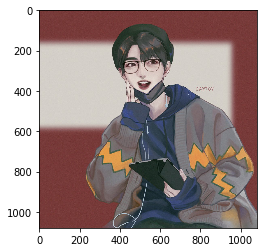

In [7]:
img = plt.imread("IMG_6896.jpg")
plt.imshow(img)
plt.show()

In [8]:
h, w, c = img.shape
h, w

(1080, 1080)

In [9]:
import random

def random_warp(img):
    height, width, channels = img.shape
    random_margin = 60
    # src
    x1, y1 = random.randint(-random_margin, random_margin), random.randint(-random_margin, random_margin)
    x2, y2 = random.randint(width - random_margin - 1, width - 1), random.randint(-random_margin, random_margin)
    x3, y3 = random.randint(width - random_margin - 1, width - 1), random.randint(height - random_margin - 1, height - 1)
    x4, y4 = random.randint(-random_margin, random_margin), random.randint(height - random_margin - 1, height - 1)   
    # dst
    dx1 = random.randint(-random_margin, random_margin)
    dy1 = random.randint(-random_margin, random_margin)
    dx2 = random.randint(width - random_margin - 1, width - 1)
    dy2 = random.randint(-random_margin, random_margin)
    dx3 = random.randint(width - random_margin - 1, width - 1)
    dy3 = random.randint(height - random_margin - 1, height - 1)
    dx4 = random.randint(-random_margin, random_margin)
    dy4 = random.randint(height - random_margin - 1, height - 1)    
    # warp:
    pts1 = np.float32([[x1, y1], [x2, y2], [x3, y3], [x4, y4]])
    pts2 = np.float32([[dx1, dy1], [dx2, dy2], [dx3, dy3], [dx4, dy4]])
    M_warp = cv2.getPerspectiveTransform(src=pts1, dst=pts2)
    img_warp = cv2.warpPerspective(src=img, M=M_warp, dsize=(width, height))
    return M_warp, img_warp

[[ 1.04915560e+00 -3.82131261e-02  1.81862037e+01]
 [ 2.89861110e-02  9.45647849e-01 -5.62864437e+00]
 [ 8.40055744e-05 -9.25688050e-05  1.00000000e+00]]


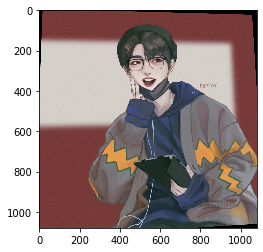

In [10]:
cv2_img = cv2.imread("IMG_6896.jpg")
H, cv2_img_warp = random_warp(cv2_img)
print(H)
img_warp = cv2.cvtColor(cv2_img_warp, cv2.COLOR_BGR2RGB)
plt.imshow(img_warp)
plt.show()

In [11]:
A = []
B = []
for i in range(15):
    x = random.randint(0, w-1) * 1.
    y = random.randint(0, h-1) * 1.
    A.append([x, y])
    src = np.array([x, y, 1]).reshape(3,)
    u, v, t = H.dot(src)
    B.append([u/t, v/t])

In [12]:
#print(src)

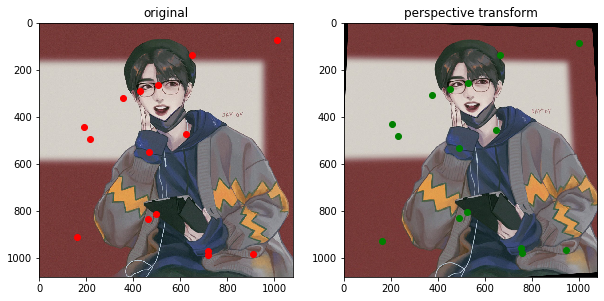

In [13]:
plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.title("original")
for p in A:
    x, y = p
    plt.scatter(x, y, c='r')
plt.imshow(img)

plt.subplot(122)
for p in B:
    u, v = p
    plt.scatter(u, v, c='g')
plt.title("perspective transform")
plt.imshow(img_warp)

plt.show()

In [14]:
H_hat = ransacMatching(A, B)

tensor([[ 1.0492e+00, -3.8213e-02,  1.8186e+01],
        [ 2.8986e-02,  9.4565e-01, -5.6288e+00],
        [ 8.4006e-05, -9.2568e-05,  1.0000e+00]], requires_grad=True)


In [15]:
H

array([[ 1.04915560e+00, -3.82131261e-02,  1.81862037e+01],
       [ 2.89861110e-02,  9.45647849e-01, -5.62864437e+00],
       [ 8.40055744e-05, -9.25688050e-05,  1.00000000e+00]])

In [16]:
B_hat = []
for p in A:
    x, y = p
    src = np.array([x, y, 1]).reshape(3, 1)
    u, v, t = H_hat.dot(src).ravel()
    B_hat.append([u/t, v/t])

In [17]:
B_hat

[[948.1305220768645, 963.3544903016417],
 [525.1404683774732, 804.5875947658391],
 [489.8318906953656, 828.2304876910405],
 [451.02317659639385, 278.47296013816816],
 [648.1930223861733, 455.8236713076325],
 [232.33522669295797, 481.05161608247374],
 [490.8210423565555, 531.2673993355047],
 [758.3265627972731, 979.9475713018516],
 [205.77044124815959, 428.5492293194933],
 [999.8116345929868, 85.1429445881366],
 [754.6213746619518, 958.7561031113718],
 [163.91740849762843, 924.985869532357],
 [377.31862890895115, 306.23024091811345],
 [527.4101817367222, 252.17923124355875],
 [665.013749600224, 136.06849262086553]]

In [18]:
B

[[948.1305975300961, 963.3545373386295],
 [525.1404581033762, 804.5876120900369],
 [489.8318764578528, 828.2305114993621],
 [451.0231630522153, 278.47296377001993],
 [648.1930080304473, 455.8236478662044],
 [232.33521436150136, 481.0516175373334],
 [490.82102716027066, 531.2673857895438],
 [758.3265994839719, 979.9476293389844],
 [205.77043449130983, 428.54923457574023],
 [999.8115706149348, 85.14294098015651],
 [754.6214086603444, 958.7561541563961],
 [163.91735198682835, 924.9859282278288],
 [377.3186197281486, 306.23024611734445],
 [527.4101630299386, 252.17923312103602],
 [665.0137159492888, 136.06850559750544]]

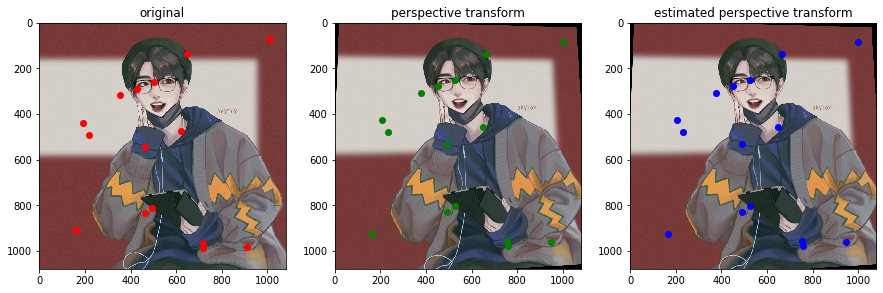

In [19]:
plt.figure(figsize=(15, 15))

plt.subplot(131)
plt.title("original")
for p in A:
    x, y = p
    plt.scatter(x, y, c='r')
plt.imshow(img)

plt.subplot(132)
for p in B:
    u, v = p
    plt.scatter(u, v, c='g')
plt.title("perspective transform")  # B (H)
plt.imshow(img_warp)

plt.subplot(133)
for p in B_hat:
    u, v = p
    plt.scatter(u, v, c='b')
plt.title("estimated perspective transform")  # B_hat (H_hat)
plt.imshow(img_warp)
plt.show()

## 9.13 肖战张小凡 诛仙 一战惊天